* price_doc: sale price (this is the target variable)
* id: transaction id
* timestamp: date of transaction
* full_sq: total area in square meters, including loggias, balconies and other non-residential areas
* life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
* floor: for apartments, floor of the building
* max_floor: number of floors in the building
* material: wall material
* build_year: year built
* num_room: number of living rooms
* kitch_sq: kitchen area
* state: apartment condition
* product_type: owner-occupier purchase or investment
* sub_area: name of the district

<b>The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.</b>

* full_all: subarea population
* male_f, female_f: subarea population by gender
* young_*: population younger than working age
* work_*: working-age population
* ekder_*: retirement-age population
* n_m_{all|male|female}: population between n and m years old
* build_count_*: buildings in the subarea by construction type or year
* x_count_500: the number of x within 500m of the property
* x_part_500: the share of x within 500m of the property
* _sqm_: square meters
* cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
* trc_: shopping malls
* prom_: industrial zones
* green_: green zones
* metro_: subway
* _avto_: distances by car
* mkad_: Moscow Circle Auto Road
* ttk_: Third Transport Ring
* sadovoe_: Garden Ring
* bulvar_ring_: Boulevard Ring
* kremlin_: City center
* zd_vokzaly_: Train station
* oil_chemistry_: Dirty industry
* ts_: Power plant

<b>A set of macroeconomic indicators, one for each date.</b>

As we can see this is quite a rich dataset with 292 different variables. But not all of these variables can be used as features, so in the next step we'll try and figure out which of these actually affect the price.

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn import model_selection, preprocessing

warnings.filterwarnings('ignore')
color = sns.color_palette()

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
train_df = pd.read_csv("../kaggle_russian_house/train.csv")
macro_df = pd.read_csv("../kaggle_russian_house/macro.csv")
print(train_df.shape)
train_df.head()

(30471, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [46]:
train_df['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

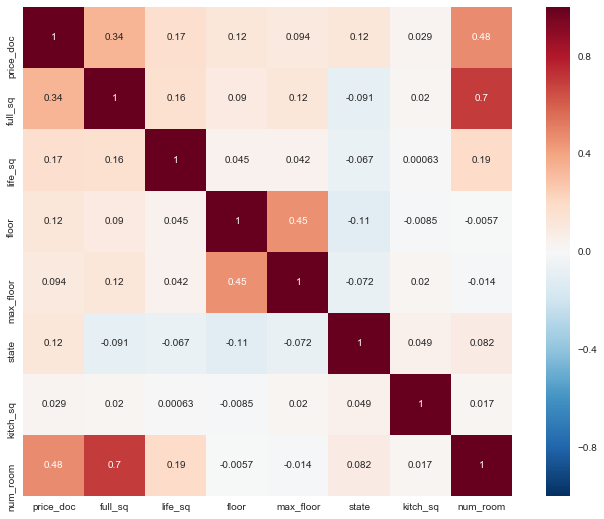

In [48]:
#Heatmap of Indoor Characteristics
df_indoor=train_df[['price_doc','full_sq','life_sq','floor','max_floor','state','kitch_sq','num_room']]
corrmat = df_indoor.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cbar=True, annot=True, square=True);
df_indoor.fillna(method='bfill',inplace=True)
plt.show()

As we can infer from the above heatmap of various recreational activities and price, Sports facilities are strongly correlated to the price. While we cannot use all of these variables because of the fact that all of the 'sport' related variables are strongly correlated to each other, thus later on we will have to select one of them to train our model.

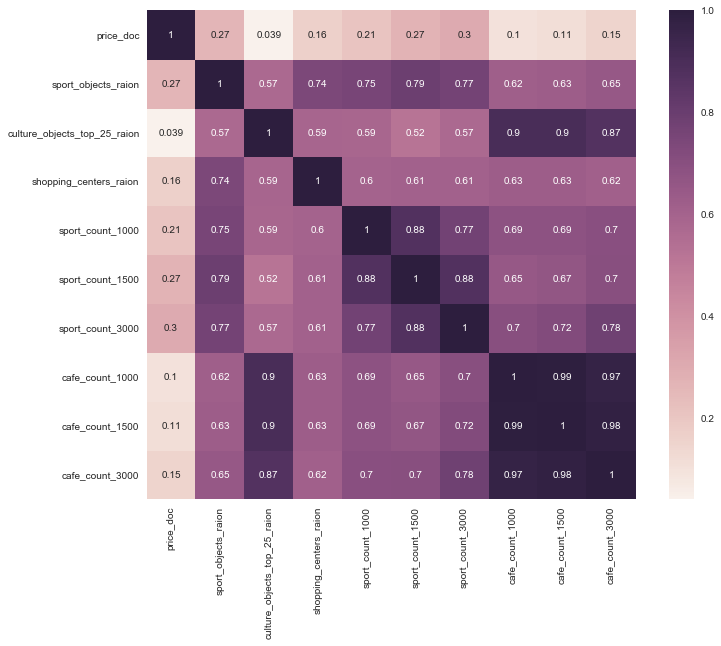

In [64]:
# Heatmap of nearby Recreational Characteristics
df_rec=train_df[['price_doc','sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion','sport_count_1000','sport_count_1500','sport_count_3000','cafe_count_1000','cafe_count_1500','cafe_count_3000']]
corrmat = df_rec.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cbar=True, annot=True, square=True);
plt.show()

None of these other recreational activities or proximity to religious institutions show any correlation to the price, thus these can be ignored. Same can be said about the next correlation matrix, which considers distance from various institutions of work.

skewness and kurtosis
kurtosis: how far away data is from the mean

In [49]:
print("Skewness: %f" % train_df['price_doc'].skew())
print("Kurtosis: %f" % train_df['price_doc'].kurt())

Skewness: 4.474745
Kurtosis: 44.027368


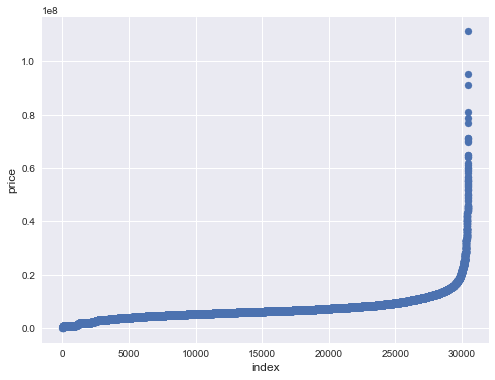

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

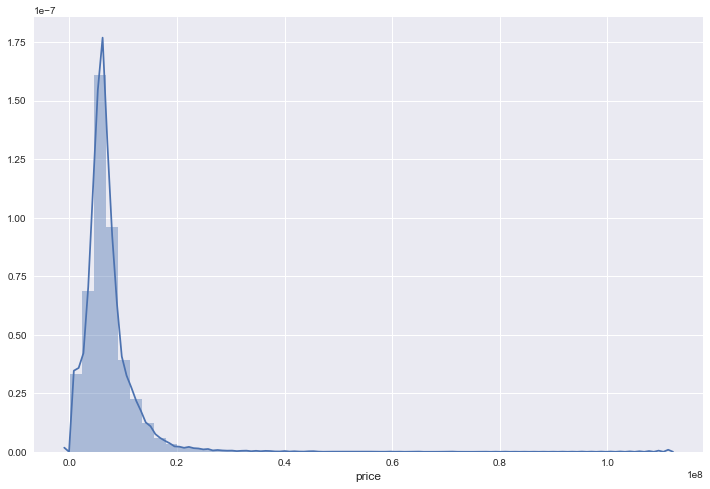

In [51]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

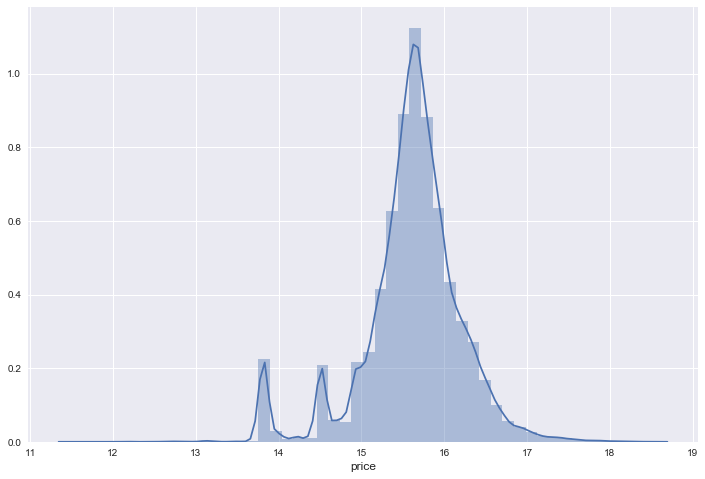

In [52]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

how the median housing price change with time. at the end there's kinda obvious linear increase.

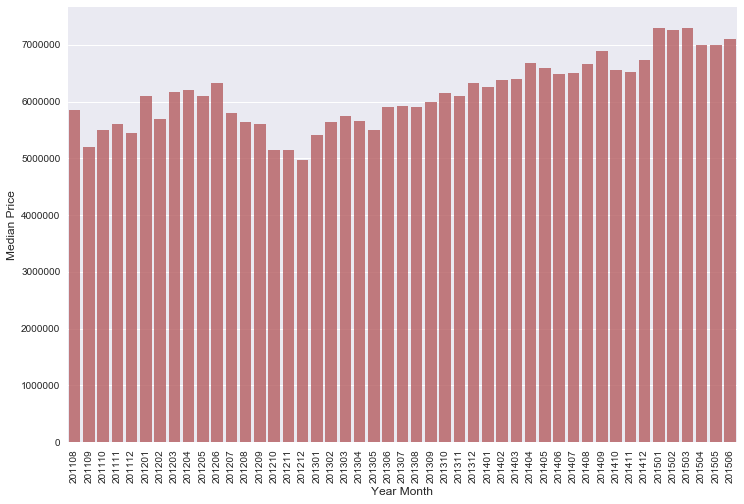

In [53]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

majority is numerical variables. obj?

In [54]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


<b>missing data</b>

[<matplotlib.text.Text at 0x123e73048>, <matplotlib.text.Text at 0x1276c2160>]

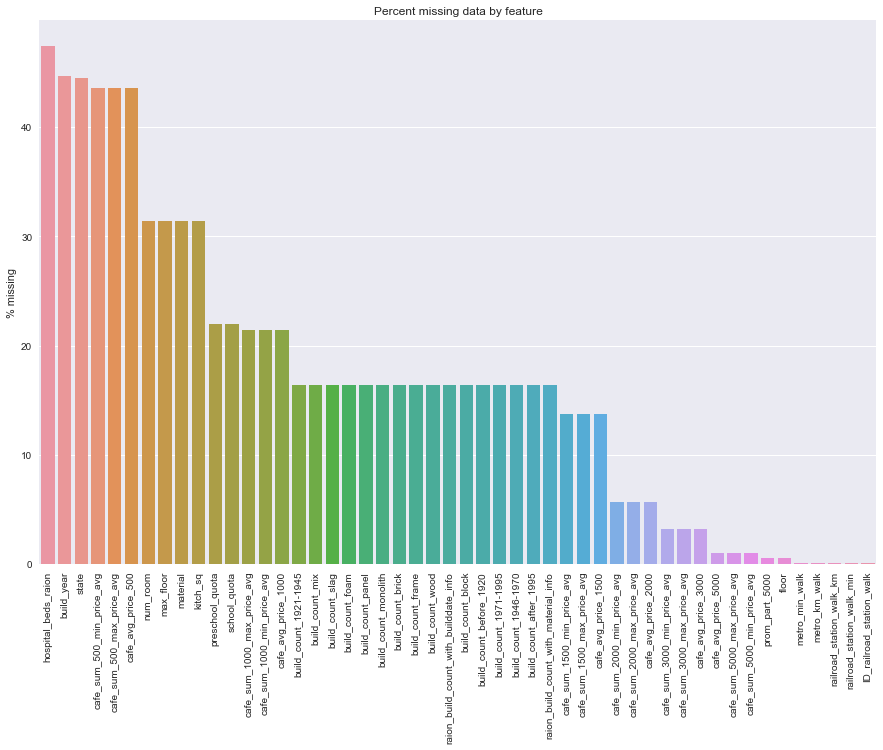

In [66]:
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

a basic xgboost model to explore the importance of variables.

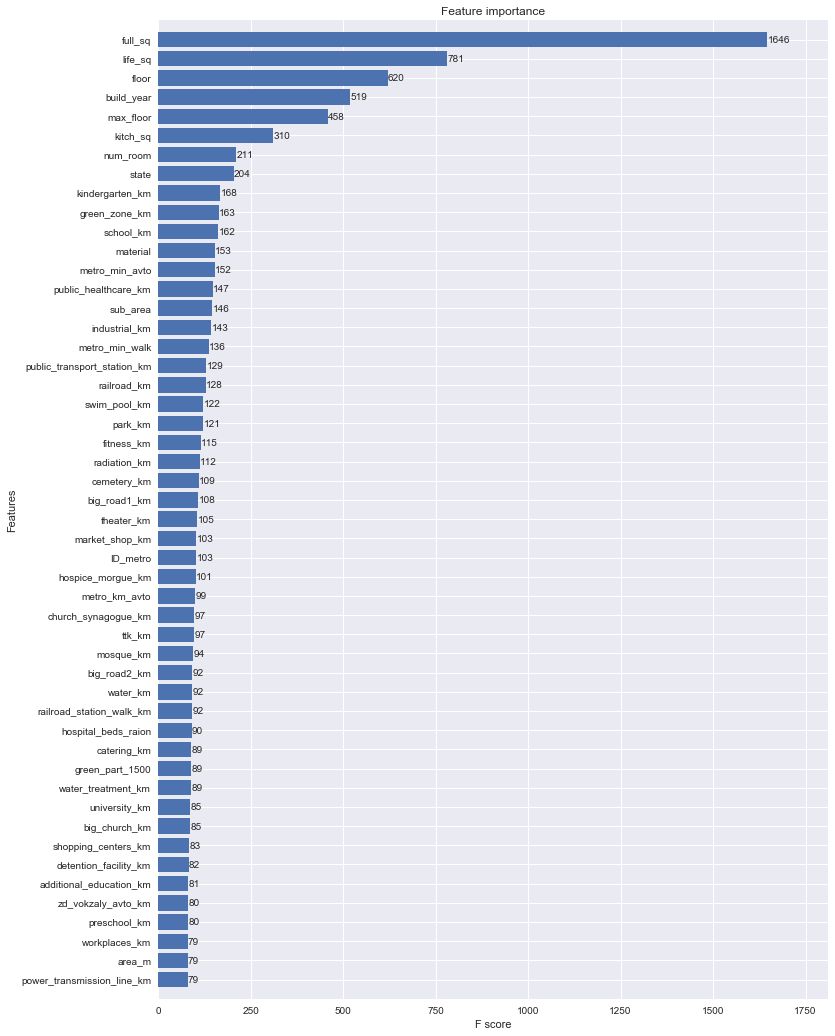

In [56]:
#transform non-numerical values
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

So the top 5 variables and their description from the data dictionary are:
full_sq - total area in square meters, including loggias, balconies and other non-residential areas
life_sq - living area in square meters, excluding loggias, balconies and other non-residential areas
floor - for apartments, floor of the building
max_floor - number of floors in the building
build_year - year built
Now let us see how these important variables are distributed with respect to target variable.

<b>Total area in square meters:</b>

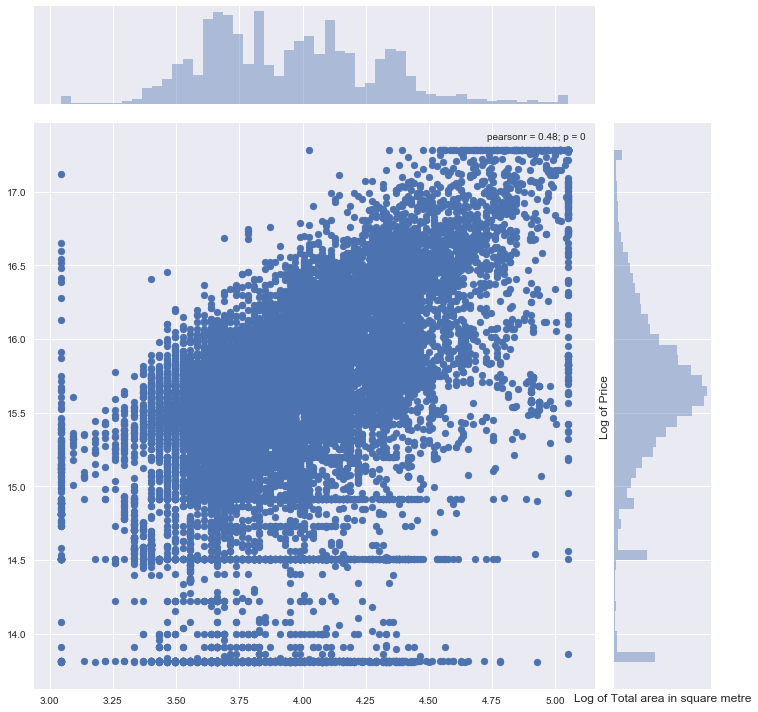

In [57]:
#remove the outliers
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

#after remove the outliers, we plot the scatter figure
plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

<b>Living area in square meters:</b>

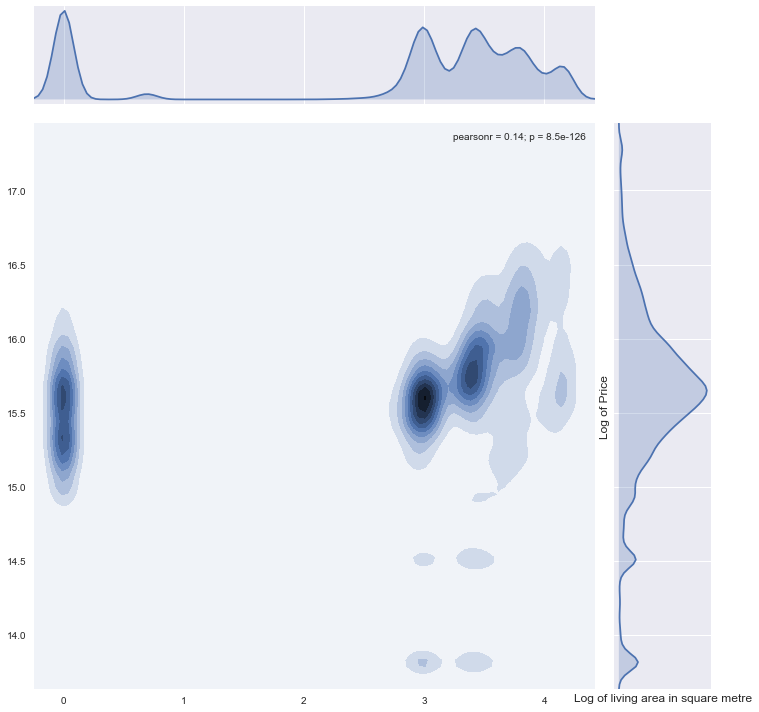

In [58]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

<b>Total Floor:</b>

for apartments, floor of the building
analysis:
There are some good drops in between (5 to 6, 9 to 10, 12 to 13, 17 to 18). Now let us see how the price changes with respect to floors.

You see the price dropping for 5 and 9-floor houses? I think this is because in Russia there were typical house constructions in the soviet era which are 5 and 9-floor typical houses. So they are usually very old houses, I think your future analysis of year variable must confirm this especially if you do year to max floor relation analysis.

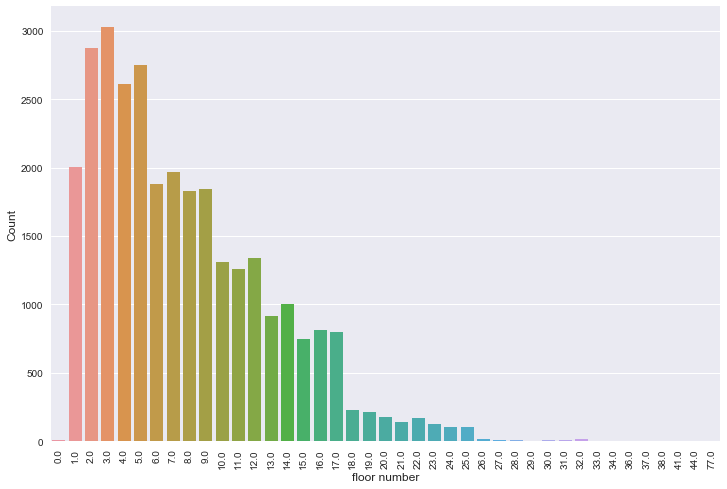

In [59]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

the relationship between price and the floor number

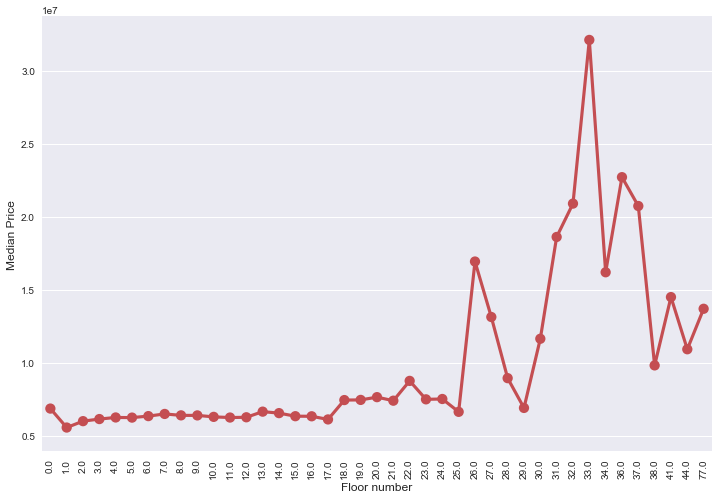

In [60]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). A sudden increase in the house price is also observed at floor 18.

<b>Max floor:</b>

Total number of floors in the building is one another important variable. So let us plot that one and see.

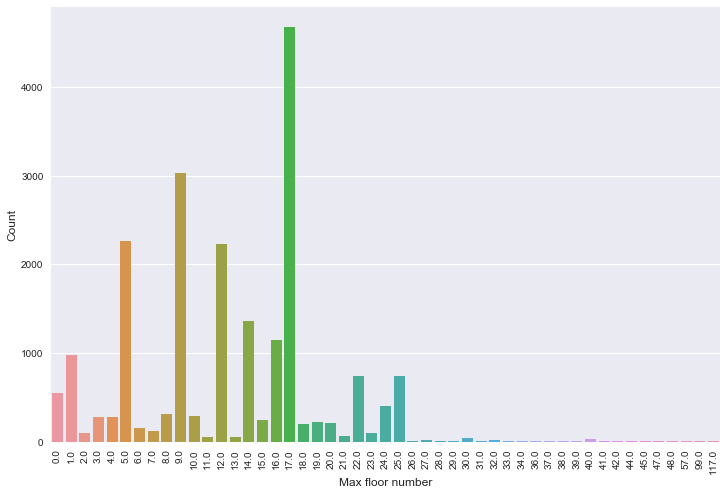

In [61]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?).
Now let us see how the median prices vary with the max floors.

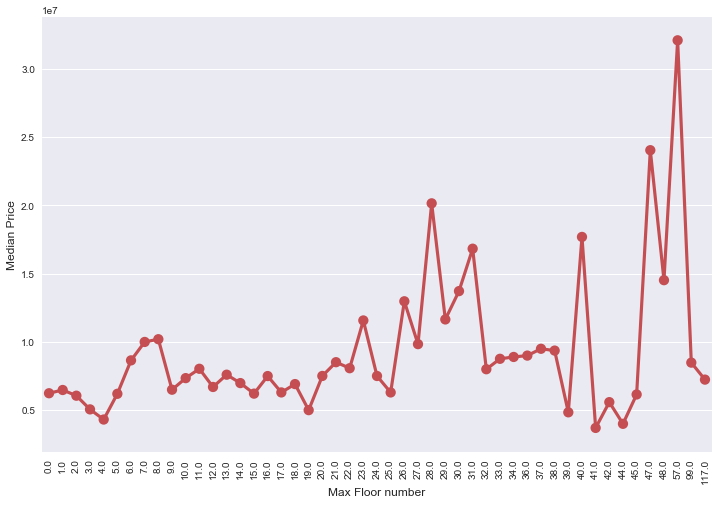

In [62]:
grouped_df = train_df.groupby('max_floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.max_floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()